<font size="10">Learning the Conjugacy Between the Tent and Logistic Maps</font>

<font size="4">TBD.</font>

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.2 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

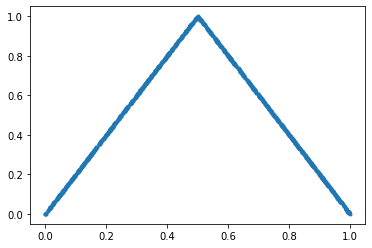

In [53]:
# Sample random points in the domain of the tent map [0,1]
N = 1000 # number of samples
xn = np.zeros((N,1))
for n in range(1,N):
    xn[n] = np.random.rand(1)
xnp1 = 2*np.minimum(xn, 1-xn) # forward iterate of the tent map
plt.plot(xn,xnp1,'.')

In [54]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 1,
                 size_y = 1,
                 activation = 'selu',
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.numblksIn = numblksIn
    self.numblksOut = numblksOut
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Encoder function 
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to logistic map variables
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential()
    
    for n in range(self.numblksOut): #adding more layers
        self.decoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to tent map variables 
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x)
    encoded_p1 = 4*encoded - 4*tf.square(encoded) # logistic map step
    decoded = self.decoder(encoded_p1)
    
    # Encoder/Decoder loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x - x_recon)))
    
    # f = rho of g of eta loss 
    xnp1 = 2*tf.math.minimum(x,1-x)
    self.add_loss(tf.reduce_mean(tf.math.square(decoded - xnp1)))
    
    # logistic map (g) loss
    xnp1_encoded = self.encoder(xnp1)
    self.add_loss(tf.reduce_mean(tf.math.square(encoded_p1 - xnp1_encoded)))
    
    return decoded

In [88]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 1 # number of variables in the tent map
size_y = 1 # number of variables in the logistic map
activation = 'selu' # nonlinear activation function at each NN layer
learning_rate = 0.00001
numblks_in = 5 # number of layers for the encoder NN
numblks_out = 5 # number of layers for the decoder NN

In [89]:
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 200)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

conjugacy.fit(xn, xnp1, callbacks = [callback], epochs = 5000)

Epoch 1/5000
32/32 [==============================] - 2s 4ms/step - loss: 4.1574
Epoch 2/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.2721
Epoch 3/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0291
Epoch 4/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0217
Epoch 5/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0197
Epoch 6/5000
32/32 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 7/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 8/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 9/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 10/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 11/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 12/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 13/5000
32/32 [====

Text(0, 0.5, '$\\hat x_{n}$')

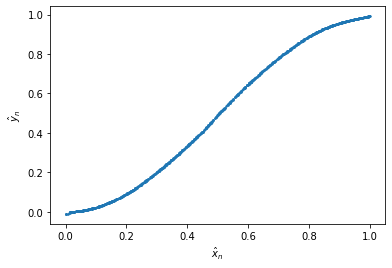

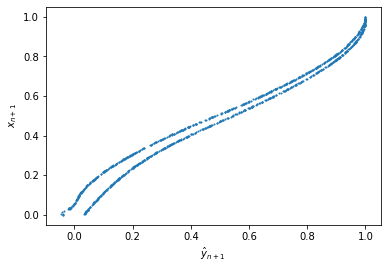

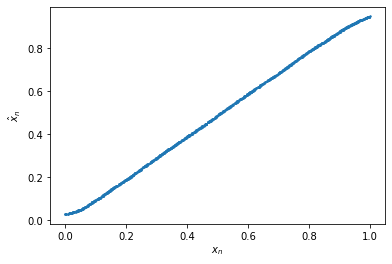

In [90]:
yn = conjugacy.encoder(xn)
xn_recon = conjugacy.decoder(yn)
ynp1 = 4*yn - 4*tf.square(yn)
xnp1_recon = conjugacy.decoder(ynp1)
ynp1_2 = conjugacy.encoder(xnp1)

# print(xn)
# print('')
# print(xn_recon.numpy())
# print('')
# print(xnp1)
# print('')
# print(xnp1_recon.numpy())

fig = plt.figure()
plt.plot(xn, yn, '.', markersize=3)
plt.xlabel('$\hat x_{n}$')
plt.ylabel('$\hat y_{n}$')

fig2 = plt.figure()
plt.plot(ynp1, xnp1, '.', markersize=2)
plt.xlabel('$\hat y_{n+1}$')
plt.ylabel('$ x_{n+1}$')

fig3 = plt.figure()
plt.plot(xn, xn_recon, '.', markersize=3)
plt.xlabel('$x_n$')
plt.ylabel('$\hat x_{n}$')

In [92]:
# Save network config
#!mkdir -p saved_conjugacy_networks
conjugacy.save('saved_conjugacy_networks/Tent2Logistic')

INFO:tensorflow:Assets written to: saved_conjugacy_networks/Tent2Logistic/assets
